In [1]:
# This code tests the trained 3d dq stepper
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#for live plotting
from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline

%run cent_env.ipynb #imports LIPM Env

[ 0.         -0.74639275] 2.42
[ 0.         -0.57488137] 2.52
[0.         0.67397237] 2.28
[0.         6.43179174] 120.7


In [2]:
# Lipm - 8 layers , 512 each
class NN(nn.Module):
    def __init__(self, inp_size, out_size):
        
        super(NN, self).__init__()
        self.l1 = nn.Linear(inp_size, 512)
        self.l2 = nn.Linear(512, 512)
        self.l3 = nn.Linear(512, 512)
        self.l4 = nn.Linear(512, 512)
        self.l5 = nn.Linear(512, 512)
        self.l6 = nn.Linear(512, 512)
        self.l7 = nn.Linear(512, 512)
        self.l8 = nn.Linear(512, 512)
        self.l9 = nn.Linear(512, out_size)
    
    def forward(self, x):
        
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        x = F.relu(self.l5(x))
        x = F.relu(self.l6(x))
        x = F.relu(self.l7(x))
        x = F.relu(self.l8(x))
        x = self.l9(x)
        return x

In [3]:
class DQStepper:
    def __init__(self, env, lr = 1e-4, gamma = 0.9, use_tarnet = False, trained_model = None):
        '''
        This is a 3d dq stepper.
        State = [x-ux, y-uy, z-uz, xd, yd, n, action_x, action_y, action_z]
        '''
        self.device = torch.device("cpu")
        self.dq_stepper = NN(11, 1).to(self.device) #state+ action -> q_value
        if trained_model:
            self.dq_stepper.load_state_dict(torch.load(trained_model))
            self.dq_stepper.eval()
        self.optimizer = torch.optim.SGD(self.dq_stepper.parameters(), lr)
        self.use_tarnet = use_tarnet
        if self.use_tarnet:
            self.dq_tar_stepper = NN(11, 1).to(self.device)
            self.dq_tar_stepper.load_state_dict(self.dq_stepper.state_dict())
            self.dq_tar_stepper.eval()
        self.gamma = gamma #discount factor
        self.no_actions = env.no_actions
        
        # This is the template of x_in that goes into the dq stepper
        self.max_step_height = 0.00
        self.max_no = 5 #number of actions with non zero step in z
        self.x_in = np.zeros((self.no_actions[0]*self.no_actions[1], 11))
        self.x_in[:,8] = np.tile(np.arange(self.no_actions[0]), self.no_actions[1])
        self.x_in[:,9] = np.repeat(np.arange(self.no_actions[1]), self.no_actions[0])
        
    def predict_action_value(self, x):
        # this function predicts the q_value for different actions and returns action and min q value
        self.x_in[:,[0, 1, 2, 3, 4, 5, 6, 7]] = x
        for e in np.random.randint(0, len(self.x_in), self.max_no):
            self.x_in[e, 10] = 2*self.max_step_height*(np.random.rand() - 0.5)
        torch_x_in = torch.FloatTensor(self.x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_stepper(torch_x_in).detach().numpy()
            action_index = np.argmin(q_values)
            action_x = int(action_index%self.no_actions[0])
            action_y = int(action_index//self.no_actions[0])
            action_z = self.x_in[action_index,10]
        return [action_x, action_y, action_z], q_values[action_index]
    
    def tar_predict_action_value(self, x):
        # this function uses tar net to predict 
        # the q_value for different actions and returns action and min q value
        self.x_in[:,[0, 1, 2, 3, 4, 5, 6, 7]] = x
        for e in np.random.randint(0, len(self.x_in), self.max_no):
            self.x_in[e, 10] = 2*self.max_step_height*(np.random.rand() - 0.5)
        torch_x_in = torch.FloatTensor(self.x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_tar_stepper(torch_x_in).detach().numpy()
            action_index = np.argmin(q_values)
            action_x = int(action_index%self.no_actions[0])
            action_y = int(action_index//self.no_actions[0])
            action_z = self.x_in[action_index,10]
        return [action_x, action_y, action_z], q_values[action_index]
    
    def predict_eps_greedy(self, x, eps = 0.1):
        # This function returns prediction based on epsillon greedy algorithm
        if np.random.random() > eps:
            return self.predict_action_value(x)[0]
        else:
            action_x = np.random.randint(self.no_actions[0])
            action_y = np.random.randint(self.no_actions[1])
            action_z = 2*self.max_step_height*(np.random.rand() - 0.5)
            
        return [action_x, action_y, action_z]
        
    def optimize(self, mini_batch, tau = 0.001):
        # This function performs one step of back propogation for the given mini_batch data
        x_in = torch.FloatTensor(mini_batch[:,0:11].copy(), device = self.device)
        y_train = torch.FloatTensor(mini_batch[:,11].copy(), device = self.device)
        for i in range(len(mini_batch)):
            if not np.isnan(mini_batch[i,12:]).all():
                if not self.use_tarnet:
                    y_train[i] += self.gamma * self.predict_action_value(mini_batch[i,12:])[1]
                else:
                    y_train[i] += self.gamma * self.tar_predict_action_value(mini_batch[i,12:])[1]

        y_train = y_train.unsqueeze(1).detach() #ensures that gradients are not computed on this
        x_train = self.dq_stepper(x_in)

        loss = F.mse_loss(x_train, y_train)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if self.use_tarnet:
            for tar_param, param in zip(self.dq_tar_stepper.parameters(), self.dq_stepper.parameters()):
                tar_param.data.copy_(tar_param.data * (1.0 - tau) + param.data * tau)
                
        return loss
    
    def live_plot(self, history, e, figsize=(15,25), window = 500, title='history'):
        clear_output(wait=True)
        fig, ax = plt.subplots(3, 1, figsize=figsize)
        ax[0].plot(history['epi_cost'], label='epi_cost', color = 'orange')
        ax[0].grid(True)
        ax[0].legend() # the plot evolves to the right
        if e > window:
            ax[1].plot(np.arange(e-window+1, e), history['epi_cost'][e-window:], label='epi_cost zoom')
            ax[1].grid(True)
            ax[1].legend() # the plot evolves to the right
        ax[2].plot(history['loss'], label='loss', color = 'black')
        ax[2].grid(True)
        ax[2].legend() # the plot evolves to the right
        ax[2].set_ylim(0, 60)
        plt.xlabel('episode')
        plt.show();
        
    def predict_q(self, x, terrain):
        #for debugging
        # this function predicts the q_value for different actions and returns action and min q value
        self.x_in[:,[0, 1, 2, 3, 4, 5, 6, 7]] = x
        self.x_in[:,10] = terrain
        torch_x_in = torch.FloatTensor(self.x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_stepper(torch_x_in).detach().numpy()
            action_index = np.argmin(q_values)
            action_x = int(action_index%self.no_actions[0])
            action_y = int(action_index//self.no_actions[0])
            action_z = self.x_in[action_index,10]
            
        return q_values, [action_x, action_y, action_z] 

In [260]:
ht = 0.28
step_time = 0.1
air_time = 0.1
env = CentEnv(ht, 0.13, 0.6, [1.0, 3.5, 0.5], [1,9])
print(env.action_space_y)
dqs = DQStepper(env, lr=1e-4, gamma=0.98, use_tarnet= True, trained_model='../../models/dqs_1')

[0.   0.04 0.09 0.13 0.18 0.26 0.37 0.52 0.73]


In [261]:
no_steps = 10 ## number of steps simulated per episode (pendulum steps)

v_des = [0.0, 0]
# v_init = [0.0*(np.random.rand() - 0.5), 2.*(np.random.rand() - 0.5)]
v_init = [.0, 0.0]
print(v_init)
state = env.reset_env([0.0, 0.0, ht, v_init[0], v_init[1], 0.0], v_des, no_steps*(2*step_time + air_time))
epi_cost = 0
for n in range(no_steps):
    terrain = 0.00
    action = dqs.predict_q(state, terrain)[1]
    next_state, cost, done = env.step_env(action, step_time, air_time)
    print(action, cost, done, state[3:5])
    epi_cost += cost
    state = next_state
    if done:
        print(epi_cost)
        break
print("showing episode...")
# env.show_episode(5)
# env.show_episode_side(5)

[0.0, 0.0]
[0, 4, 0.0] 0.39 False [0. 0.]
[0, 2, 0.0] 0.11 False [0.         0.09648857]
[0, 2, 0.0] 0.25 False [0.         0.01564153]
[0, 1, 0.0] 0.16 False [0.         0.05362258]
[0, 1, 0.0] 0.43 False [ 0.         -0.01523672]
[0, 3, 0.0] 0.4 False [ 0.         -0.09982851]
[0, 1, 0.0] 0.21 False [ 0.         -0.10367108]
[0, 0, 0.0] 0.21 False [0.         0.02912016]
[0, 1, 0.0] 0.41 False [0.         0.02234669]
[0, 3, 0.0] 0.4 False [ 0.         -0.09459664]
showing episode...


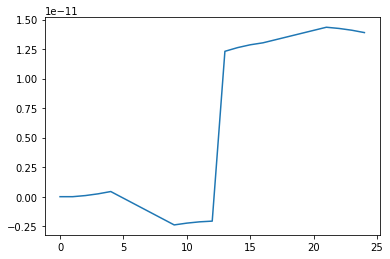

In [603]:
# plt.plot(env.sim_data[6])

In [262]:
ht = 0.3
step_time = 0.1
air_time = 0.1
env_main = CentEnv(ht, 0.13, 0.5, [0.5, 3.0, 1.5], [11,9])
env_x = CentEnv(ht, 0., 0.5, [0.5, 3.0, 1.5], [11,1])
dqs_x = DQStepper(env_x, lr=1e-4, gamma=0.98, use_tarnet= True, trained_model='../../models/dqs_1_str')
env_y = CentEnv(ht, 0.13, 0.6, [0.5, 3.0, 1.5], [1,9])
dqs_y = DQStepper(env_y, lr=1e-4, gamma=0.98, use_tarnet= True, trained_model='../../models/dqs_1')
print(env_y.action_space_y)

[0.   0.04 0.09 0.13 0.18 0.26 0.37 0.52 0.73]


In [270]:
no_steps = 10 ## number of steps simulated per episode (pendulum steps)

v_des = [0., 0]
v_init = [3.0*(np.random.rand() - 0.5), 1.0*(np.random.rand() - 0.5)]
# v_init = [0.5, 0.0]
print(v_init)
state = env_main.reset_env([0.0, 0.0, ht, v_init[0], v_init[1], 0.0], v_des, no_steps*(2*step_time + air_time))
epi_cost = 0
for n in range(no_steps):
    terrain = 0.00
    # for x axis
    state_x = state.copy()
    state_x[1] = 0.0
    state_x[4] = 0.0
    action_x = dqs_x.predict_q(state_x, terrain)[1] 
    # for y axis
    state_y = state.copy()
    state_y[0] = 0.0
    state_y[3] = 0.0
    action_y = dqs_y.predict_q(state_y, terrain)[1] 
    action = np.array([int(action_x[0]), int(action_y[1]), 0])

    next_state, cost, done = env_main.step_env(action, step_time, air_time)
    print(action, cost, done, state[0:5])
    epi_cost += cost
    state = next_state
    if done:
        print(epi_cost)
        break
print("showing episode...")
# env_main.show_episode(5)
# env_main.show_episode_side(5)

[0.9575987516862537, -0.3306849199252061]
[9 1 0] 2.52 False [ 0.          0.065       0.3         0.95759875 -0.33068492]
[5 2 0] 1.13 False [-0.10215502 -0.01017055  0.29996423  0.48230179 -0.08756689]
[2 4 0] 2.25 False [-0.08096681  0.04466866  0.29992299 -0.29291545  0.04528383]
[4 5 0] 1.95 False [ 0.02673282 -0.07592104  0.29992418 -0.51091901 -0.05740284]
[4 3 0] 2.31 False [-0.00953466  0.05997378  0.29992415 -0.39539793 -0.14609368]
[1 4 0] 2.75 False [-0.05942506 -0.05122655  0.29992415 -0.63073122 -0.07606111]
[4 3 0] 0.9 False [ 0.06975422  0.04719444  0.29992415 -0.5691521  -0.10756921]
[7 5 0] 2.63 False [ 0.07969575 -0.06963777  0.29992415  0.07043358 -0.16415044]
[7 0 0] 1.56 False [ 0.00119227  0.03554314  0.29992415  0.40583736 -0.31078731]
[4 4 0] 1.78 False [-0.07425229 -0.02644674  0.29992415  0.09863078 -0.23740331]
showing episode...
